# DiP Lab Project

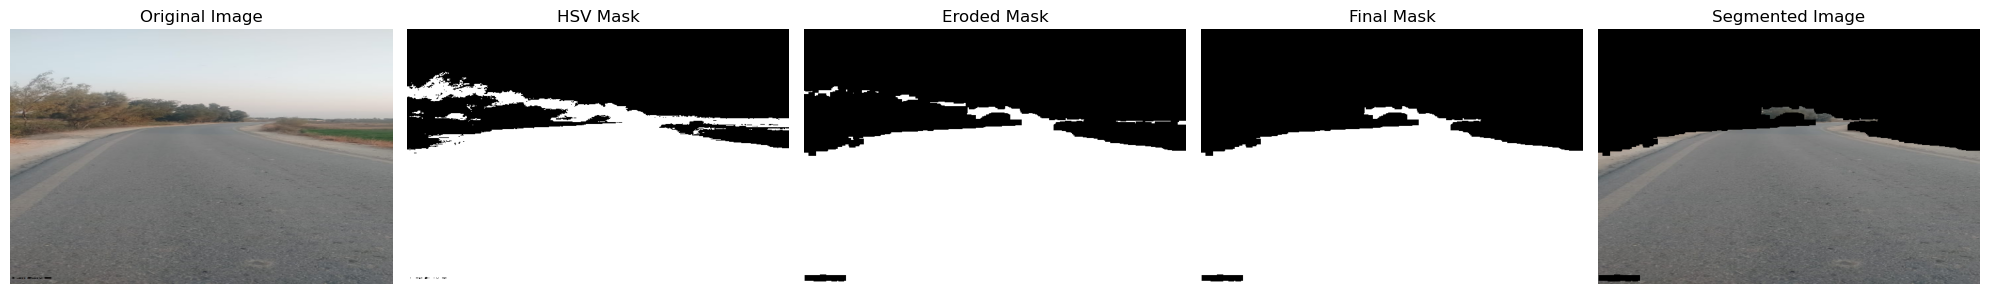

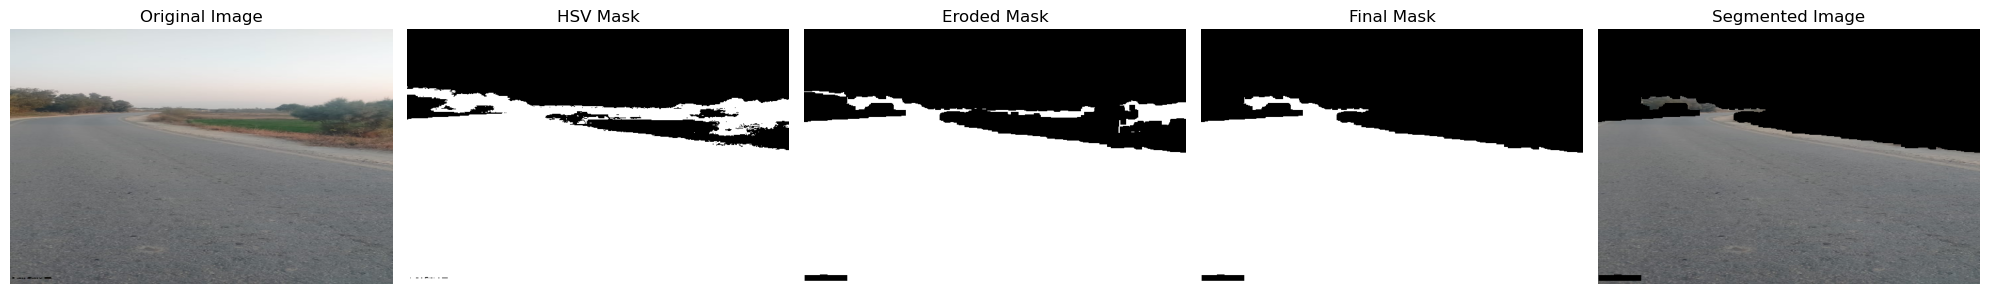

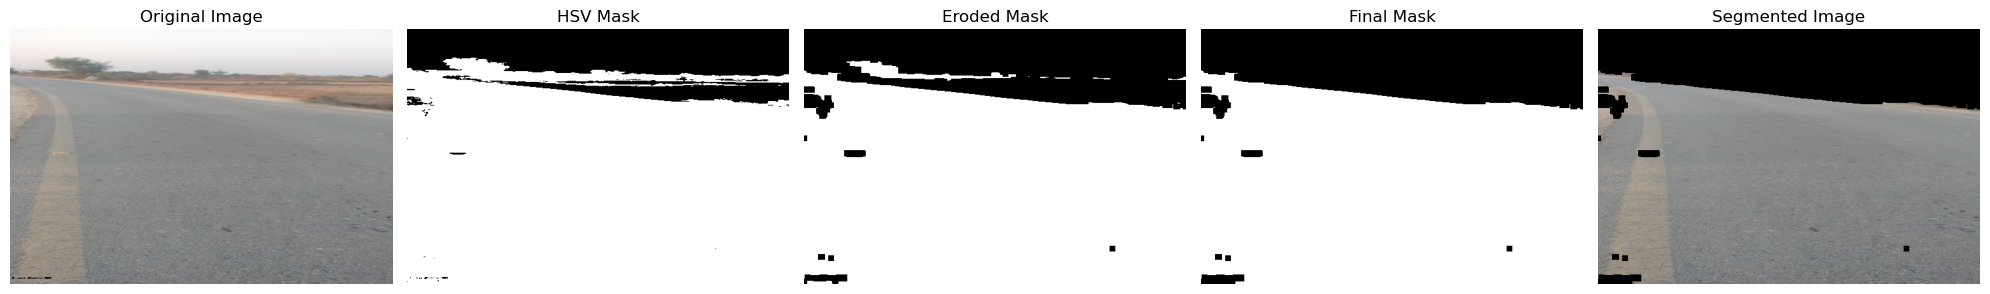

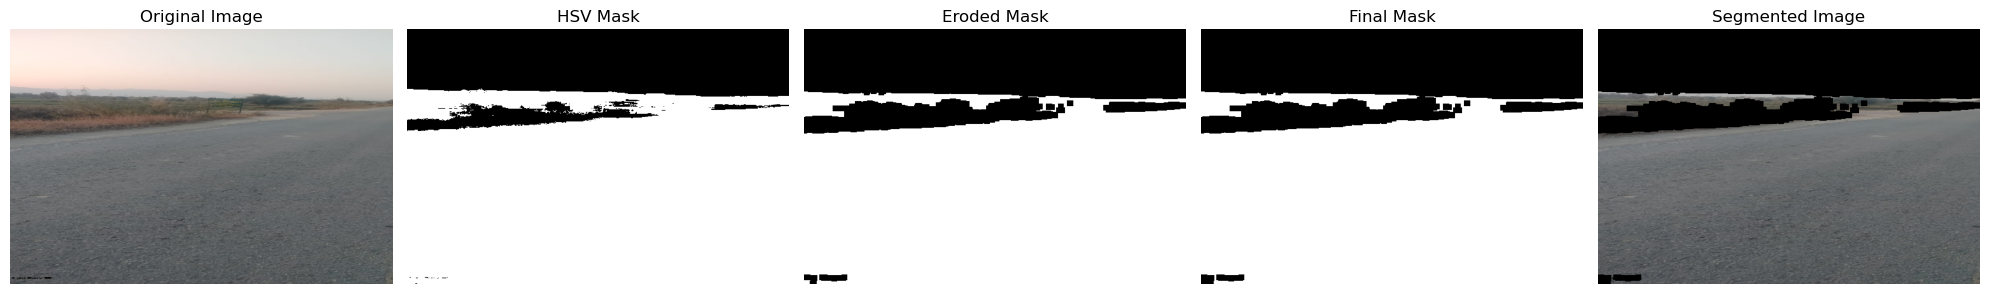

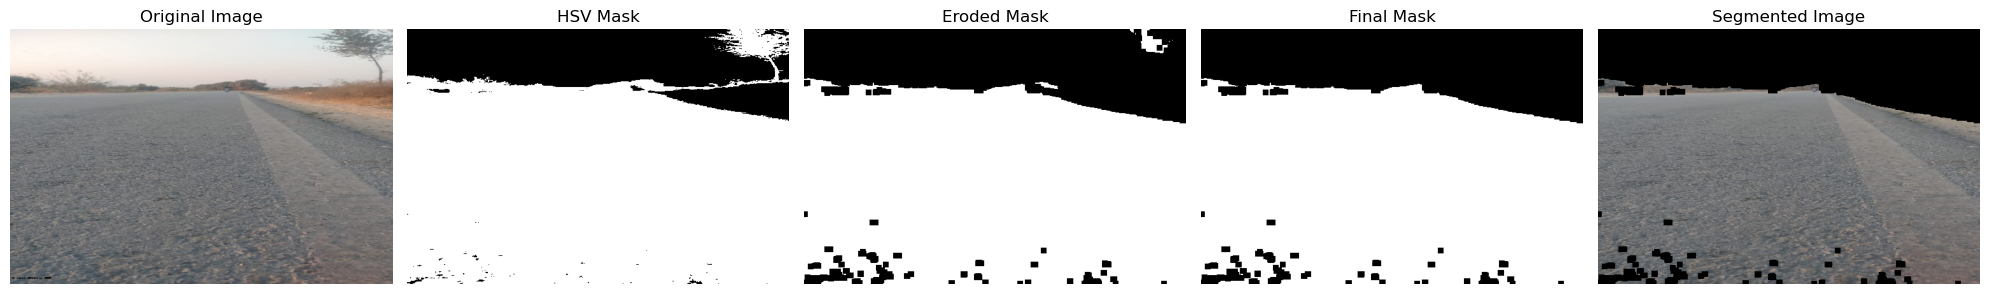

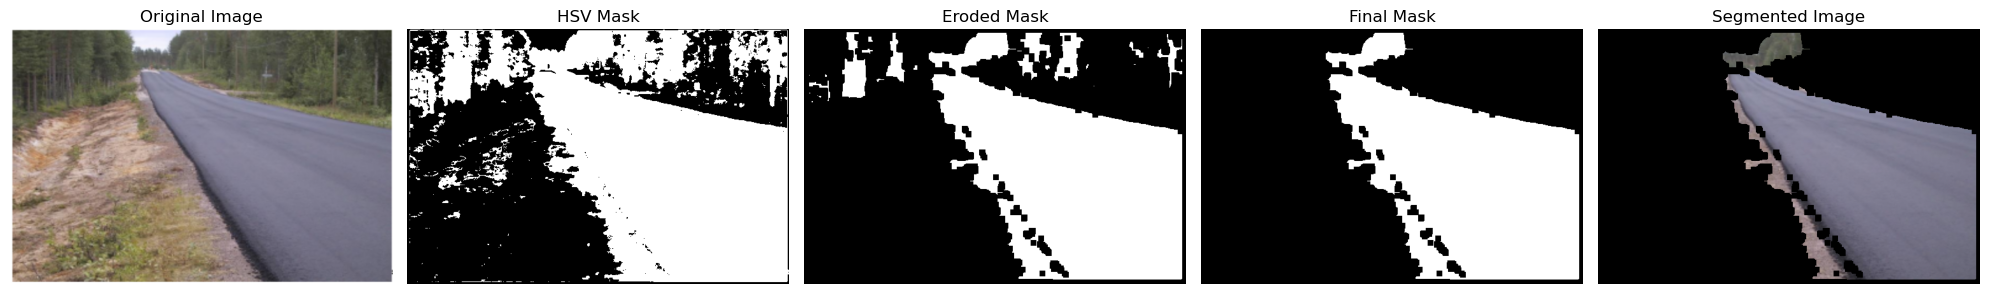

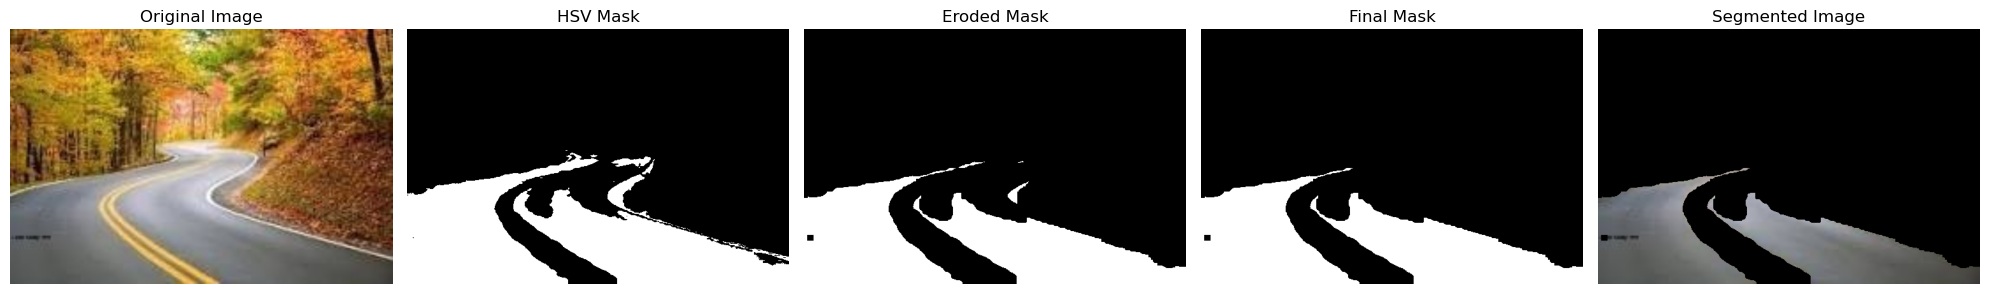

SystemExit: 0

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PyQt5.QtWidgets import (QApplication, QMainWindow, QPushButton, QLabel, QFileDialog, QVBoxLayout, QWidget, QScrollArea, QHBoxLayout)
from PyQt5.QtGui import QPixmap, QImage
from PyQt5.QtCore import Qt

def segment_road_with_hsv_mask(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to load image.")
        return None, None, None, None, None

    image = cv2.resize(image, (600, 400))

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_gray_hsv = np.array([0, 0, 0])
    upper_gray_hsv = np.array([179, 50, 190])

    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create the mask based on HSV range
    mask_hsv = cv2.inRange(hsv, lower_gray_hsv, upper_gray_hsv)

    # Apply erosion to remove noise
    kernel = np.ones((5, 5), np.uint8)
    mask_eroded = cv2.erode(mask_hsv, kernel, iterations=2)

    # Remove small connected components
    mask_final = mask_eroded.copy()
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_eroded, connectivity=8)
    for i in range(1, num_labels):  # Start from 1 to skip the background
        if stats[i, cv2.CC_STAT_AREA] < 3000:  # If the area is less than 500 pixels
            mask_final[labels == i] = 0

    # Perform segmentation using the processed mask
    segmented_image = cv2.bitwise_and(rgb, rgb, mask=mask_final)

    return rgb, mask_hsv, mask_eroded, mask_final, segmented_image

def convert_cv_to_pixmap(cv_image):
    height, width, channels = cv_image.shape
    bytes_per_line = channels * width
    q_image = QImage(cv_image.data, width, height, bytes_per_line, QImage.Format_RGB888).rgbSwapped()
    return QPixmap.fromImage(q_image)

def convert_gray_to_pixmap(cv_gray):
    height, width = cv_gray.shape
    bytes_per_line = width
    q_image = QImage(cv_gray.data, width, height, bytes_per_line, QImage.Format_Grayscale8)
    return QPixmap.fromImage(q_image)

class RoadSegmentationApp(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Road Segmentation")
        self.setGeometry(100, 100, 800, 600)
        self.setStyleSheet("background-color: #f4f4f9; font-family: Arial, sans-serif;")

        self.central_widget = QWidget()
        self.setCentralWidget(self.central_widget)

        self.scroll_area = QScrollArea()
        self.scroll_area.setWidgetResizable(True)
        self.scroll_widget = QWidget()
        self.scroll_layout = QVBoxLayout(self.scroll_widget)
        self.scroll_area.setWidget(self.scroll_widget)

        self.main_layout = QVBoxLayout(self.central_widget)

        # Title Label at the top
        self.title_label = QLabel("Road Segmentation")
        self.title_label.setAlignment(Qt.AlignCenter)
        self.title_label.setStyleSheet("font-size: 24px; font-weight: bold; color: #333; padding: 20px;")
        self.main_layout.addWidget(self.title_label)

        # Upload button
        self.upload_button = QPushButton("Upload Image")
        self.upload_button.setStyleSheet("""
            QPushButton {
                background-color: #4CAF50;
                color: white;
                border-radius: 5px;
                padding: 10px;
                font-size: 16px;
            }
            QPushButton:hover {
                background-color: #45a049;
            }
        """)
        self.upload_button.clicked.connect(self.upload_image)
        self.main_layout.addWidget(self.upload_button)

        # Add the scrollable area for the images
        self.main_layout.addWidget(self.scroll_area)

        # Image labels with titles above them
        self.image_titles = []
        self.image_labels = []

        titles = ["Original Image", "HSV Mask", "Eroded Mask", "Final Mask", "Segmented Image"]
        for title in titles:
            title_label = QLabel(title)
            title_label.setAlignment(Qt.AlignCenter)
            title_label.setStyleSheet("font-size: 16px; font-weight: bold; color: #333; padding: 10px;")
            self.image_titles.append(title_label)
            self.scroll_layout.addWidget(title_label)

            image_label = QLabel()
            image_label.setAlignment(Qt.AlignCenter)
            image_label.setMinimumSize(400, 300)
            self.scroll_layout.addWidget(image_label)
            self.image_labels.append(image_label)

    def upload_image(self):
        options = QFileDialog.Options()
        file_path, _ = QFileDialog.getOpenFileName(self, "Open Image File", "", "Images (*.png *.jpg *.jpeg);;All Files (*)", options=options)

        if file_path:
            try:
                rgb, mask_hsv, mask_eroded, mask_final, segmented_image = segment_road_with_hsv_mask(file_path)

                # Set the images in the corresponding image labels
                self.image_labels[0].setPixmap(convert_cv_to_pixmap(rgb).scaled(400, 300, Qt.KeepAspectRatio))
                self.image_labels[1].setPixmap(convert_gray_to_pixmap(mask_hsv).scaled(400, 300, Qt.KeepAspectRatio))
                self.image_labels[2].setPixmap(convert_gray_to_pixmap(mask_eroded).scaled(400, 300, Qt.KeepAspectRatio))
                self.image_labels[3].setPixmap(convert_gray_to_pixmap(mask_final).scaled(400, 300, Qt.KeepAspectRatio))
                self.image_labels[4].setPixmap(convert_cv_to_pixmap(segmented_image).scaled(400, 300, Qt.KeepAspectRatio))

                # Plot the results using matplotlib
                plt.figure(figsize=(20, 10))

                plt.subplot(1, 5, 1)
                plt.title("Original Image")
                plt.imshow(rgb)
                plt.axis('off')

                plt.subplot(1, 5, 2)
                plt.title("HSV Mask")
                plt.imshow(mask_hsv, cmap='gray')
                plt.axis('off')

                plt.subplot(1, 5, 3)
                plt.title("Eroded Mask")
                plt.imshow(mask_eroded, cmap='gray')
                plt.axis('off')

                plt.subplot(1, 5, 4)
                plt.title("Final Mask")
                plt.imshow(mask_final, cmap='gray')
                plt.axis('off')

                plt.subplot(1, 5, 5)
                plt.title("Segmented Image")
                plt.imshow(segmented_image)
                plt.axis('off')

                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"Error: {e}")

if __name__ == "__main__":
    app = QApplication(sys.argv)
    window = RoadSegmentationApp()
    window.show()
    sys.exit(app.exec_())
